In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig
import matplotlib.patches as patches
import cv2
import pandas as pd
import sys
import poissonimageediting as poisson
from tqdm.auto import tqdm

np.set_printoptions(threshold=sys.maxsize)

/home/leohsu-cs/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]

    if center is None:
        center = (w / 2, h / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

In [3]:
def retrive_ellipse(src, u, v, A, o):
    image = src.copy()

    # Extracting the dimensions of the image
    height, width = image.shape[:2]

    # Eigenvalue decomposition to find axes lengths and orientation
    vals, vecs = eig(A)
    major_axis_length = 1 / np.sqrt(vals[0])
    minor_axis_length = 1 / np.sqrt(vals[1])
    angle = np.arctan2(vecs[1, 0], vecs[0, 0])

    # Create an x, y coordinate grid of shape (height, width)
    y, x = np.ogrid[:height, :width]
    x = x - u
    y = y - v

    # Ellipse equation derived from the quadratic form
    ellipse_mask = ((x * np.cos(angle) + y * np.sin(angle))**2 / major_axis_length**2 +
                    (y * np.cos(angle) - x * np.sin(angle))**2 / minor_axis_length**2) <= 1
    
    not_rotate_image = np.zeros_like(image)
    not_rotate_image[ellipse_mask] = image[ellipse_mask]

    image = rotate(image, o - 180, center = (u, v))

    em_int = np.where(ellipse_mask == True, 255, 0).astype(np.uint8)
    em_int = np.dstack([em_int, em_int, em_int])
    em_int = rotate(em_int, o - 180, center = (u, v))
    em_int = em_int[:, :, 0]
    ellipse_mask = np.where(em_int == 255, True, False).astype(bool)

    indices = np.where(ellipse_mask)
    min_y, max_y = indices[0].min(), indices[0].max()
    min_x, max_x = indices[1].min(), indices[1].max()

    # Masking the image
    selected_region = np.zeros_like(image)
    selected_region[ellipse_mask] = image[ellipse_mask]

    return selected_region[min_y:max_y + 1, min_x:max_x + 1], ellipse_mask[min_y:max_y + 1, min_x:max_x + 1], not_rotate_image


In [4]:
image = cv2.imread('test_imgs/01.png').astype(np.uint8)
dataset_images_dir = "data/holiday_images"
target_df = pd.read_pickle('data/target_df.pkl')
dataset_df = pd.read_pickle('data/holiday_df.pkl')

In [5]:
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

target_descriptors = np.array(target_df['descriptor'].tolist(), dtype = np.float32)
dataset_descriptors = np.array(dataset_df['descriptor'].tolist(), dtype = np.float32)

matches = matcher.match(target_descriptors, dataset_descriptors)

target_df['match_idx'] = np.array([match.trainIdx for match in matches])

In [6]:
target_df = target_df.sort_values(by = ['size'], ascending = [False])
print(target_df.shape)

(772, 13)


In [7]:
def add_alpha_channel(image):
    # Check if the input image already has an alpha channel
    if image.shape[2] == 4:
        print("Image already has an alpha channel.")
        return image

    # Get the dimensions of the input image
    height, width = image.shape[:2]

    # Create an alpha channel with full opacity (255)
    alpha_channel = np.ones((height, width), dtype=np.uint8) * 255

    # Add the alpha channel to the input image
    rgba_image = cv2.merge((image, alpha_channel))

    return rgba_image

In [8]:
def rotate_image(image, angle):
    # Get the image dimensions
    (h, w) = image.shape[:2]
    
    # Calculate the center of the image
    center = (w // 2, h // 2)
    
    # Compute the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Calculate the cosine and sine of the rotation angle
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    # Compute the new bounding dimensions of the image
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))
    
    # Adjust the rotation matrix to account for the translation
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]
    
    # Perform the actual rotation and return the image
    rotated = cv2.warpAffine(image, M, (new_w, new_h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0,0))
    
    return rotated

In [9]:
def paste_image_with_alpha(bg_img, overlay_img, center_x, center_y):
    """
    Overlays `overlay_img` onto `bg_img` centered at (center_x, center_y) using the alpha channel.
    
    Args:
    - bg_img (numpy.ndarray): The background image (larger image), shape (H, W, 4).
    - overlay_img (numpy.ndarray): The image to overlay (smaller image), shape (h, w, 4).
    - center_x (int): The x-coordinate of the center point.
    - center_y (int): The y-coordinate of the center point.
    
    Returns:
    - numpy.ndarray: The resulting image with the overlay.
    """
    
    # Get dimensions
    H, W, _ = bg_img.shape
    h, w, _ = overlay_img.shape
    
    # Calculate the top-left corner of the overlay_img
    start_x = max(center_x - w // 2, 0)
    start_y = max(center_y - h // 2, 0)
    
    # Calculate the range of overlay_img to use
    overlay_start_x = max(0, w // 2 - center_x)
    overlay_start_y = max(0, h // 2 - center_y)
    
    overlay_end_x = min(w, W - center_x + w // 2)
    overlay_end_y = min(h, H - center_y + h // 2)
    
    bg_end_x = start_x + overlay_end_x - overlay_start_x
    bg_end_y = start_y + overlay_end_y - overlay_start_y
    
    # Apply the overlay using the alpha channel
    alpha_overlay = overlay_img[overlay_start_y:overlay_end_y, overlay_start_x:overlay_end_x, 3] / 255.0
    
    for c in range(0, 3):
        if c == 3:  # Alpha channel
            bg_img[start_y:bg_end_y, start_x:bg_end_x, c] = np.where(alpha_overlay > 0, overlay_img[overlay_start_y:overlay_end_y, overlay_start_x:overlay_end_x, c], bg_img[start_y:bg_end_y, start_x:bg_end_x, c])
        else:  # RGB channels
            bg_img[start_y:bg_end_y, start_x:bg_end_x, c] = np.where(alpha_overlay > 0, overlay_img[overlay_start_y:overlay_end_y, overlay_start_x:overlay_end_x, c], bg_img[start_y:bg_end_y, start_x:bg_end_x, c])
    
    return bg_img

In [10]:
def show_img(img):
    print(img.shape)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [11]:
def show_results(src, mask, canvas, this_o):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    
    axs[0].imshow(src)
    axs[0].set_title('src')
    axs[0].axis('off')

    axs[1].imshow(np.dstack([mask, mask, mask]))
    axs[1].set_title('mask')
    axs[1].axis('off')
    
    axs[2].imshow(canvas)
    axs[2].set_title('canvas')
    axs[2].axis('off')

    plt.show()
    print(this_o)

  0%|          | 0/772 [00:00<?, ?it/s]

index & row 771 image_name                                                    01.png
coordinate                                        (575.417, 419.393)
scale                                                      192.07462
orientation                                              -170.069473
matrix             [[2.79806e-05, -4.99744e-06], [-4.99744e-06, 5...
eigenvalues         [2.7105663086150243e-05, 5.6524836913849755e-05]
eigenvectors       [[-0.9850175819893834, 0.17245394507458628], [...
semi_major_axis                                            192.07462
semi_minor_axis                                           133.008789
size                                                    80260.192263
angle                                                      -2.968272
descriptor         [15.0, 55.0, 55.0, 9.0, 17.0, 12.0, 19.0, 24.0...
match_idx                                                        190
Name: 771, dtype: object 

(640, 794, 3)


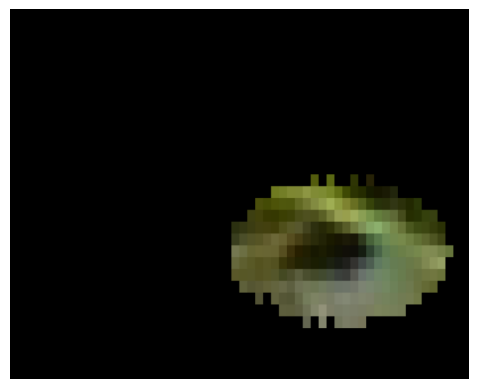

(640, 794, 3)


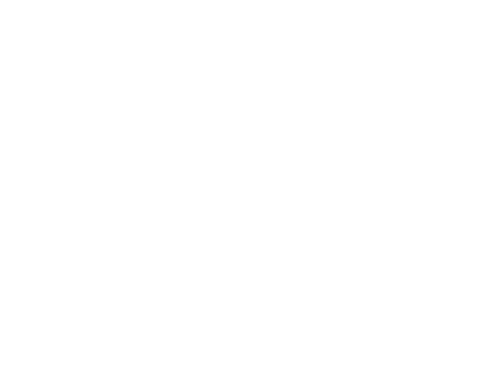

[0. 1.]
omega shape:  (74560, 2)
step1: filling coefficient matrix: A


step2: filling gradient matrix: b


step3: solve Au = b


  0%|          | 0/772 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [15]:
# canvas = np.full((image.shape[0], image.shape[1], image.shape[2] + 1), 255, dtype = np.float32)
canvas = np.full((image.shape[0], image.shape[1], image.shape[2]), 1.0, dtype = np.float32)
colored = np.full((image.shape[0], image.shape[1]), False)


for index, row in tqdm(target_df.iterrows(), total=target_df.shape[0]):
    print("index & row", index, row, '\n')

    match_idx = row['match_idx']
    match_image_name  = dataset_df.loc[match_idx, 'image_name']
    match_image = add_alpha_channel(cv2.imread(f'{dataset_images_dir}/{match_image_name}').astype(np.uint8))
    
    # retrieve the ellipse
    match_u, match_v = dataset_df.loc[match_idx, 'coordinate']
    match_A = np.array(dataset_df.loc[match_idx, 'matrix'])
    match_o = dataset_df.loc[match_idx, 'orientation']
    cropped_region, cropped_mask, _ = retrive_ellipse(match_image, match_u, match_v, match_A, match_o)
    cropped_height, cropped_width = cropped_region.shape[0], cropped_region.shape[1]
    
    # calculate the features of the ellipse
    this_u, this_v = row['coordinate']
    this_A = np.array(row['matrix'])
    this_o = row['orientation']
    this_region, _, not_rotate_this_region = retrive_ellipse(image, this_u, this_v, this_A, this_o)
    this_height, this_width = this_region.shape[0], this_region.shape[1]
    resized_cropped = cv2.resize(cropped_region, (this_width, this_height), interpolation=cv2.INTER_AREA)
    resized_cropped = np.pad(resized_cropped, ((128, 128), (128, 128), (0, 0)), 'constant', constant_values=0)
    # here you forgot to resize the mask
    resized_mask = cv2.resize(cropped_mask.astype(np.uint8), (this_width, this_height), interpolation=cv2.INTER_AREA)
    resized_mask = np.pad(resized_mask, ((128, 128), (128, 128)), 'constant', constant_values=False)
    indices = np.where(resized_mask)
    min_y, max_y = indices[0].min(), indices[0].max()
    min_x, max_x = indices[1].min(), indices[1].max()

    resized_cropped = resized_cropped[min_y:max_y + 1, min_x:max_x + 1]
    resized_mask = resized_mask[min_y:max_y + 1, min_x:max_x + 1]

    # Convert resized_cropped to have an alpha channel
    # resized_cropped_with_alpha = np.dstack((resized_cropped, np.zeros(resized_cropped.shape[:2], dtype=np.uint8)))

    # # Set alpha values based on resized_mask
    # resized_cropped_with_alpha[:, :, 3] = np.where(resized_mask, 255, 0)

    # resized_cropped_with_alpha = rotate_image(resized_cropped_with_alpha, 180 - this_o)

    null_canvas_4_src = np.zeros_like(canvas).astype(np.uint8)
    # the image is collage 
    src = (paste_image_with_alpha(null_canvas_4_src, resized_cropped, int(this_u), int(this_v)) / 255.0).astype(np.float32)
    
    # solve the equation
    this_vals, this_vecs = eig(this_A)
    this_major_axis_length = 1 / np.sqrt(this_vals[0])
    this_minor_axis_length = 1 / np.sqrt(this_vals[1])
    this_angle = np.arctan2(this_vecs[1, 0], this_vecs[0, 0])
    this_y, this_x = np.ogrid[:canvas.shape[0], :canvas.shape[1]]
    this_x = this_x - this_u
    this_y = this_y - this_v
    this_ellipse_mask = ((this_x * np.cos(this_angle) + this_y * np.sin(this_angle))**2 / this_major_axis_length**2 +
                         (this_y * np.cos(this_angle) - this_x * np.sin(this_angle))**2 / this_minor_axis_length**2) <= 1
    mask = np.all(src != 0, axis=-1)
    mask = np.where(mask == True, 255, 0)
    mask = mask / 255.0

    show_img(src)
    show_img(canvas)
    print(np.unique(mask))
    canvas, overlap = poisson.poisson_blend(src, mask, canvas, 'mix', 'temp')
    
    # normalize for next iteration
    canvas = (canvas / 255.0).astype(np.float32)
    
canvas = (canvas * 255.0).astype(np.uint8)
show_results(src, mask, canvas, this_o)
    

(100, 200)


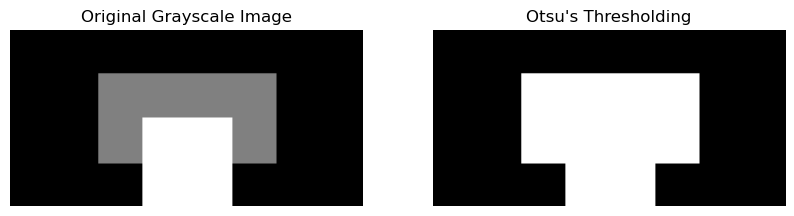

In [14]:
src = np.zeros((100, 200), dtype=np.uint8)
cv2.rectangle(src, (50, 25), (150, 75), 128, -1)  # Gray rectangle
cv2.rectangle(src, (75, 50), (125, 100), 255, -1)  # White rectangle

# Step 2: Apply Otsu's thresholding
ret, mask = cv2.threshold(src, 0, 255, cv2.THRESH_OTSU)
print(mask.shape)


# Step 3: Display the original and thresholded images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Grayscale Image')
plt.imshow(src, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Otsu's Thresholding")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.show()